In [1]:
import os, glob, fitz, shutil
import pandas as pd
from PIL import Image
from pprint import pprint
import streamlit as st

In [2]:
data_fld = "data"
raw_fld = os.path.join(data_fld, "raw")
clean_fld = os.path.join(data_fld, "clean")

In [3]:
def normalize_col(dff, col):
    if col in dff.columns:
        dff[col] = (
            dff[col]
            .str.strip()
            .str.replace("\s{2,}", " ", regex=True)
            .str.normalize("NFKD")
            .str.encode("ascii", errors="ignore")
            .str.decode("utf-8")
            .str.upper()
        )
    else:
        st.write(f"{col} does not exist in df.")
    return dff

def get_df():
    # Create df of all CSV's to normalize them.
    all_files = glob.glob(os.path.join(clean_fld, "*.csv"))
    li = []
    for filename in all_files:
        dff = pd.read_csv(filename)
        fname = os.path.basename(filename)
        name = fname.split(".")[0]
        dff["filename"] = name
        dff["fileacct"] = " ".join(name.split()[:-2])
        dff["filedate"] = "-".join(name.split()[-2:])
        li.append(dff)

    df = pd.concat(li, axis=0, ignore_index=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    df["filedate"] = pd.to_datetime(df["filedate"]).dt.date

    df = df.drop(
        columns=[
            "Price",
            "Currency",
            "Exchange Rate",
            "Payment Method",
            "Category Code",
        ]
    ).rename(columns={"Price (Exchanged)": "Price"})
    df["Price"] = df["Price"].round(2)

    df = normalize_col(df, "Name")
    df = normalize_col(df, "Comment")
    # df = _group_names(df)

    return df.sort_values(by=["filedate", "Receipt Index"]).reset_index(drop=True)

def get_receipt_pic(pdf, receipt_index):

    clean_fld = os.path.join("data", "clean")
    filename = os.path.join(clean_fld, pdf)

    d = _create_pdf_dict(filename)

    try:
        receipt = d[receipt_index]
    except:
        return None

    pic_filepath = _generate_pic(filename, receipt)

    return _get_pic(pic_filepath)


def _create_pdf_dict(filename):

    doc = fitz.open(filename)
    all_d = {}
    for page in doc:
        num = page.number
        txt = page.get_text("text")
        txt = txt.split("\n")
        receipts = []


        # print(page.get_image_info())

        for t in txt:
            if " • " in t and t not in receipts:
                print(t)
                receipts.append(t)
        
        # img_info = page.get_images()
        # # print(img_info)
        # for img in img_info:
        #     pprint(img)

        if receipts:
            d = {}
            for r in receipts:  # Important to sort
                items = r.split(" • ")
                d[int(items[0])] = {
                    "Vendor": items[1],
                    "Date": items[2],
                    "Comment": items[3],
                    "Page": num,
                }
            d_list = sorted(list(d.keys()))

            images = page.get_images()
            img_dict = {int(i[7][2:]): i[0] for i in images}
            img_dict_sorted = {i: img_dict[i] for i in sorted(img_dict)}

            # Append to receipt dict (d) the image info.
            for i, img in enumerate(img_dict_sorted):
                rec_id = d_list[i]
                d[rec_id]["img_name"] = img
                d[rec_id]["img_xref"] = img_dict_sorted[img]

            all_d = {**all_d, **d}

    return all_d


def _generate_pic(filename, receipt):

    xref = receipt["img_xref"]
    num = receipt["Page"]
    pic_name = receipt["img_name"]

    doc = fitz.open(filename)

    pix = fitz.Pixmap(doc, xref)
    if pix.n >= 5:
        pix = fitz.Pixmap(fitz.csRGB, pix)

    pic_fld = os.path.join("data", "img")
    if os.path.exists(pic_fld):
        shutil.rmtree(pic_fld)
    os.mkdir(pic_fld)

    filename = f"page{num}_{pic_name}_xref{xref}.png"
    filepath = os.path.join(pic_fld, filename)

    pix.writePNG(filepath)

    return filepath


def _get_pic(filepath):

    return Image.open(filepath)

Receipt Index                            13
Date                             2021-03-08
Name                       NARESH RAMNICLAL
Price                               -1500.0
Category Name                BF - Utilities
Comment          TWO PROPANE TANK EXCHANGES
filename                    OE Base 2021 03
fileacct                            OE Base
filedate                         2021-03-01
Name: 1600, dtype: object
2 • EDM • 03/01/21 • Electricity
3 • Tofo Trash Dump • 03/01/21 • 1x trash removal
5 • Associação África Missions • 03/02/21 • Rent for March
8 • Somoconta • 03/02/21 • February accounting
9 • INSS • 03/02/21 • INSS
10 • Paizinho Comercial • 03/03/21 • Screws for Smethurst veranda bed
11 • Pep • 03/05/21 • Mugs for worker kitchen
12 • Gindolo • 03/08/21 • Gloves and hinges for outdoor kitchen windows 
13 • Naresh Ramniclal • 03/08/21 • Two propane tank exchanges
14 • EDM • 03/08/21 • Electricity
15 • Tofo Trash Dump • 03/11/21 • Trash Removal (vines)
16 • EDM • 03/13/21 •

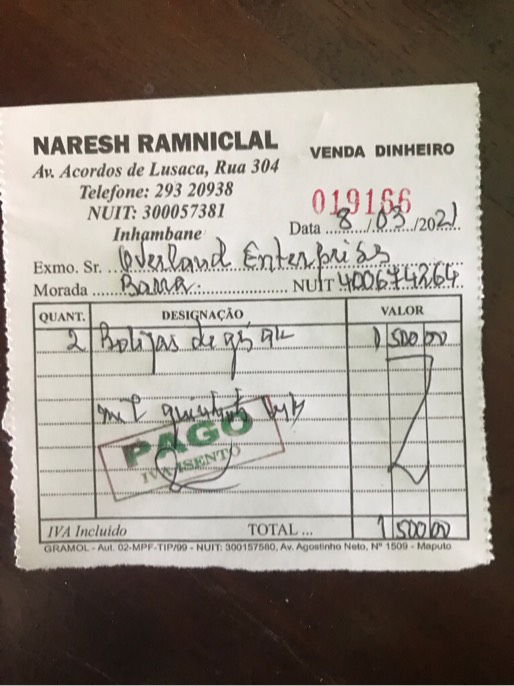

In [4]:
df_main = get_df()

receipt_id = 1600

row = df_main.iloc[receipt_id]
filename = row["filename"]
receipt_index = row["Receipt Index"]
print(row)

image = get_receipt_pic(filename + ".pdf", receipt_index)
image
# if image:
#     container.image(image, use_column_width=True)
# else:
#     container.write("Receipt Does Not Exist")